In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image

In [20]:
labels = {
0: "T-shirt/top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle boot"
}

In [21]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [22]:
def get_train_test_cat(x_train: np.ndarray, x_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray, label=0) -> (np.ndarray, np.ndarray):
    x_train = x_train[y_train == label]
    x_test = x_test[y_test == label]
    return x_train, x_test

In [23]:
# TODO: get train data
# 1
##########################################################
sneaker_train, sneaker_test = get_train_test_cat(X_train, X_test, Y_train, Y_test, label=7) # Hint: het is wat er uit de functie komt
##########################################################

In [24]:
np.shape(sneaker_train)

(6000, 28, 28)

In [25]:
from sklearn.preprocessing import MinMaxScaler

# TODO: Init datascalar
# 2
############################################################
scaler_in = MinMaxScaler()
x_flat =  np.reshape(sneaker_train, (len(sneaker_train), -1)) # Hint: het is een vector, en de functie staat hieronder
data_scaler = scaler_in.fit(x_flat) # Hint: sklearn gebruikt altijd fit
#############################################################

def unroll(data: np.ndarray) -> np.ndarray:
    """
    Maakt van de data een vector (samples, -1)
    :param data:
    :return:
    """
    return np.reshape(data, (len(data), -1))

def add_dummy_dim(data: np.ndarray) -> np.ndarray:
    """
    Voegd een extra dummy dim to aan het eind
    :param data:
    :return:
    """
    return np.expand_dims(data, axis=-1)

def norm_data(train: np.ndarray, test: np.ndarray, shape: str ='flat') -> (np.ndarray, np.ndarray):
    """
    Transformeerd data voor de autoencoder
    flat: een vector
    dummy: een extra dim aan het eind voor non compressie versie (is heel traag, gebruik deze niet)
    None: Geeft de originele dims terug. Werkt prima, maar niet omdat het hoort. (Zie tensorflow docs voor meer informatie)
    :param train:
    :param test:
    :param shape:
    :return:
    Genormaliseerde (eventueel getransformeerde) data
    """
    unroll_train = unroll(train)
    unroll_test = unroll(test)
    _train = data_scaler.transform(unroll_train)
    _test = data_scaler.transform(unroll_test)
    if shape=='flat':
        return _train, _test
    if shape=='dummy':
        return add_dummy_dim(train), add_dummy_dim(test)
    else:
        return np.reshape(_train, np.shape(train)), np.reshape(_test, np.shape(test))

def reverse_data(data: np.ndarray) -> np.ndarray:
    """
    Geeft weer de orginele data terug. Is voornamelijk voor het plotten van de data.
    In de tussentijd werk je alleen met de genormaliseerde data
    :param data:
    :return:
    Inverse van de getransformeerde data
    """
    if len(np.shape(data)) == 3:
        flat = unroll(data)
        inv_roll = data_scaler.inverse_transform(flat)
        img = np.reshape(inv_roll, (len(data), np.shape(data)[1], np.shape(data)[2]))
    elif len(np.shape(data)) == 4:
        flat = np.squeeze(data)
        inv_roll = data_scaler.inverse_transform(flat)
        img = np.reshape(inv_roll, (len(data), np.shape(data)[1], np.shape(data)[2]))
    else:
        flat = data
        inv_roll = data_scaler.inverse_transform(flat)
        img = np.reshape(inv_roll, (len(data), int(np.sqrt(np.shape(data)[1])), int(np.sqrt(np.shape(data)[1]))))

    return img


In [26]:
# TODO: insert train set
# 3
####################################################
norm_sneaker_train, norm_sneaker_test = norm_data(sneaker_train, sneaker_test, shape="flat") # Hint: het is weer de train test set
####################################################

In [27]:
np.shape(x_flat)

(6000, 784)

In [28]:
import tensorflow as tf
from tensorflow.python.keras.models import Model

class AutoEncoder(Model):
  def __init__(self, size_features):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(128, activation="relu"),
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(8, activation="relu")
              ])
    self.decoder = tf.keras.Sequential([
                  tf.keras.layers.Dense(16, activation="relu"),
                  tf.keras.layers.Dense(32, activation="relu"),
                  tf.keras.layers.Dense(64, activation="relu"),
                  tf.keras.layers.Dense(128, activation="relu"),
                  tf.keras.layers.Dense(size_features, activation="sigmoid")
              ])
  def call(self, x, **kwargs):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [29]:
# TODO: init het model met de hoeveelheid features van je train set
# 5
##############################################
model = AutoEncoder(np.shape(norm_sneaker_train)[-1]) # Hint: bij een unroll/flat is het aantal features gelijk aan de lengte van de vector (aka het aantal pixels)
#############################################

In [30]:
# TODO: train het model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
# 6
####################################################################################################
model.compile(optimizer='adam', loss='mse') # Hint: het maakt niet uit
history = model.fit(norm_sneaker_train, norm_sneaker_train, epochs=200, batch_size=120, # Hint: Wat erin gaat moet er ook weer uit
                    validation_data=(norm_sneaker_test, norm_sneaker_test), # Hint: Je test set
####################################################################################################
                    shuffle=True,
                    callbacks=[early_stopping]
                   )

Epoch 1/200
50/50 [==============================] - 2s 26ms/step - loss: 0.0770 - val_loss: 0.0339
Epoch 2/200
50/50 [==============================] - 1s 20ms/step - loss: 0.0337 - val_loss: 0.0317
Epoch 3/200
50/50 [==============================] - 1s 20ms/step - loss: 0.0316 - val_loss: 0.0294
Epoch 4/200
50/50 [==============================] - 1s 20ms/step - loss: 0.0296 - val_loss: 0.0272
Epoch 5/200
50/50 [==============================] - 1s 20ms/step - loss: 0.0255 - val_loss: 0.0223
Epoch 6/200
50/50 [==============================] - 1s 20ms/step - loss: 0.0228 - val_loss: 0.0211
Epoch 7/200
50/50 [==============================] - 1s 20ms/step - loss: 0.0216 - val_loss: 0.0202
Epoch 8/200
50/50 [==============================] - 1s 20ms/step - loss: 0.0210 - val_loss: 0.0199
Epoch 9/200
50/50 [==============================] - 1s 20ms/step - loss: 0.0205 - val_loss: 0.0196
Epoch 10/200
50/50 [==============================] - 1s 20ms/step - loss: 0.0200 - val_loss: 0.0190

In [31]:
# TODO: Tijd om je model te testen
# 7
###########################################
pred = model.predict(norm_sneaker_test) # Hint: er zijn 2 manieren: encode-decode OF gebruik de build in functie van tensorflow die altijd volgt na .fit
###########################################

In [32]:
# TODO: om weer bruikbare data te maken moeten we terug naar de echte waardes
# 8
################################################################################################
pred_images = reverse_data(pred) # Je moet de data omdraaien. De functie is al gemaakt. Als het goed is gegaan moet dit zonder aanpassingen gaan
real_images = reverse_data(norm_sneaker_test) # Hint: Een set die je eerder gemaakt hebt
################################################################################################
# (extra hint in het geval iets niet werkt: Je moet misschien een squeeze uitvoeren)

In [33]:
# Optioneel: plot je data om te kijken of het goed is gegaan
#################################################
Image.fromarray(np.uint8(real_images[1]))
#################################################

In [37]:
def get_losses(train: np.ndarray, test: np.ndarray, y_labels: dict) -> np.ndarray:
    """
    Berekend alle losses van alle labels in de fashion MNIST set
    :param train:
    :param test:
    :param y_labels:
    :return:
    Een dict met key: label en value: losses
    """
    losses = dict()
    for label, value in y_labels.items():
        x_train, x_test = get_train_test_cat(X_train, X_test, Y_train, Y_test, label=label)
        _, test = norm_data(x_train, x_test, shape="flat")
        losses[value] = tf.keras.losses.mse(model.predict(unroll(test)), unroll(test)).numpy()
    return losses

In [38]:
# Get losses van alle labels
performance = get_losses(X_train, X_test, y_labels=labels)

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
# TODO: selecteer een threshold
# 9
###########################################################
threshold = np.mean(performance['Sneaker']) + 2*np.std(performance['Sneaker']) + 0.1 # Hint: loss van de ...
############################################################
# Hint: wat de threshold is maakt eigenlijk niet uit. Het is standaard om +/-2stdev te gebruiken oftewel ongeveer 5%. Maar dit hoeft niet.

In [69]:
def plot_detection(losses: np.ndarray, name:str, offset:float=0) -> None:
    """
    Plot een histogram van alle losses en de threshold
    :param losses:
    :param name:
    :param offset:
    :return:
    None (een print statement)
    """
    sns.histplot(losses, bins=50)
    _ = plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))

    passed = tf.math.less(losses, threshold+offset)
    print(f"Detection rate {name}: {100-tf.math.count_nonzero(passed).numpy()/len(losses)*100:.2f}%")

Detection rate T-shirt/top: 100.00%
Detection rate Trouser: 100.00%
Detection rate Pullover: 100.00%
Detection rate Dress: 100.00%
Detection rate Coat: 100.00%
Detection rate Sandal: 7.70%
Detection rate Shirt: 100.00%
Detection rate Sneaker: 0.00%
Detection rate Bag: 92.50%
Detection rate Ankle boot: 13.80%


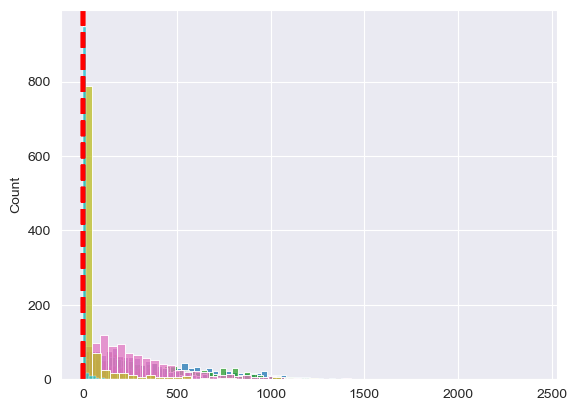

In [70]:
for key, values in performance.items():
    plot_detection(values, key, offset=0.01)